In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # generic plotting
import seaborn as sns
from sklearn.model_selection import train_test_split # splits data into different sets
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

df = pd.read_csv("/content/survey lung cancer.csv")
#check if the dataset is loaded
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
#check the size of the dataset
df.shape

(309, 16)

The chosen dataset has **16** attributes and **309** instances.

#Initial Analysis

Lets do some preprocessing to check for missing values, noisy data, and other inconsistencies.Preprocessing helps us to create a clean dataset which makes the analysis more accurate and better.

In [ ]:
#Let's check for null values
df.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

There are **no** null values.

In [ ]:
#Let's check for duplicates instances.
df.duplicated().sum()

33

It appears that there are 33 duplicate instances which need to be removed.

In [ ]:
#Let's remove the duplicate instances
df.drop_duplicates(inplace=True)
df.shape

(276, 16)

After removing the duplicate values,our dataset now has 276 instances.

Now,let's convert categorical labels into numerical values.This step is primarily helpful when plotting to view trends between attributes.

In [ ]:
for x in df:
    if x == 'AGE': # Skip the 'AGE' column as it is continuous numerical attribute
        continue
    df[x]=LabelEncoder().fit_transform(df[x])

df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


For Gender attribute,0 is female and 1 is male.
For all other categorical attributes,0 is NO and 1 is YES.

#Exploratory Data Analysis

EDA helps us to analyze the data using visual techniques. It is used to discover trends, patterns, or to check assumptions with the help of statistical summary and graphical representations. 

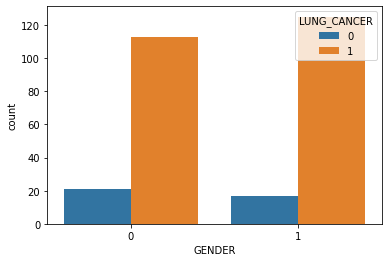

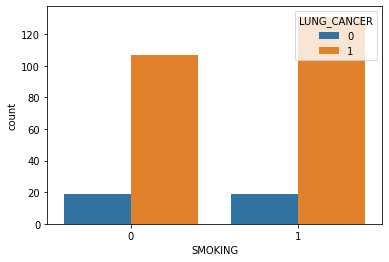

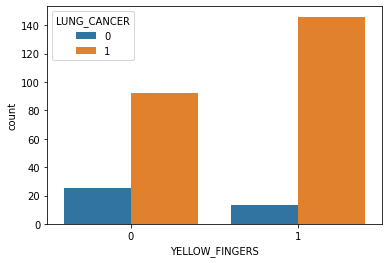

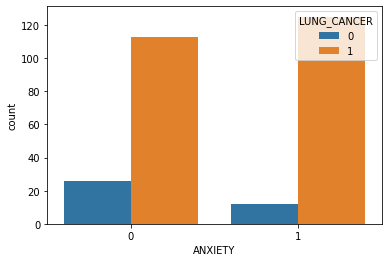

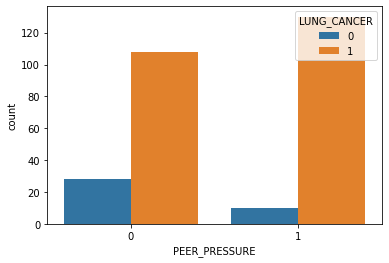

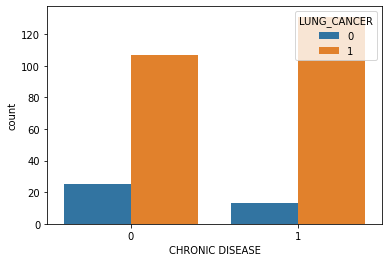

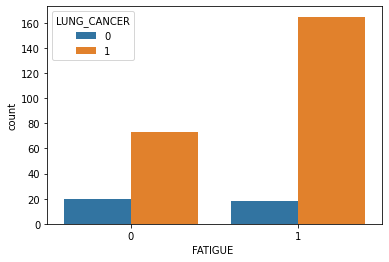

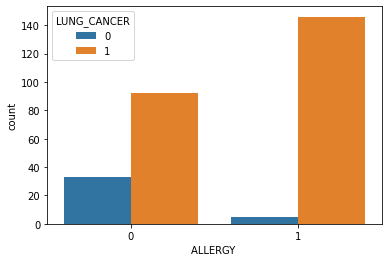

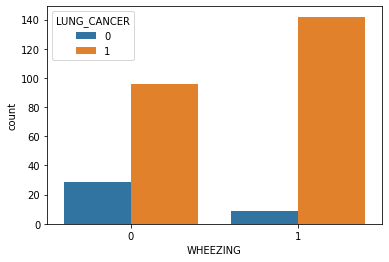

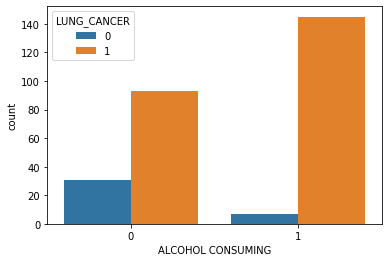

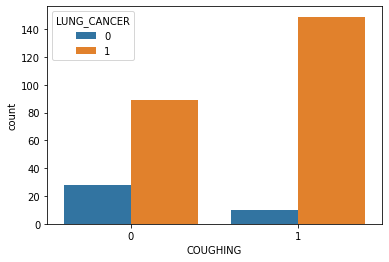

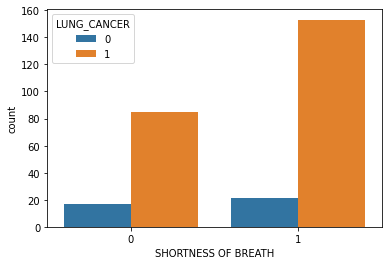

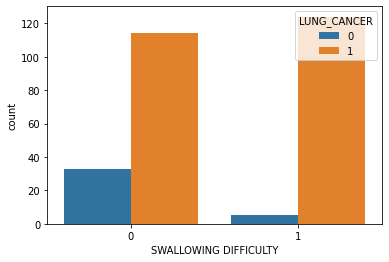

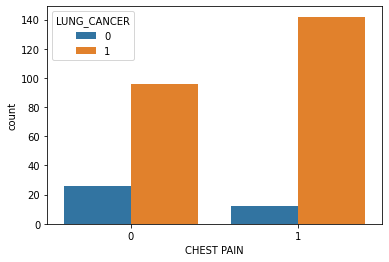

In [ ]:
#For categorical attributes
df_cat_attributes = [col for col in df.columns if col != "AGE" and col!='LUNG_CANCER' ]
for attr in df_cat_attributes:
  sns.countplot(x =attr, hue = "LUNG_CANCER", data = df)
  plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

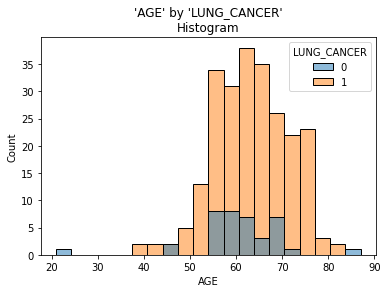

In [ ]:
#For continuous attribute
sns.histplot(data=df, x='AGE', hue='LUNG_CANCER')
plt.title("'AGE' by 'LUNG_CANCER'\nHistogram")
plt.show

Most of the attributes seem to have reasonable representation between their 0(NO) and 1(YES) labels.
The dataset is unbalanced with a much stronger representation for 'LUNG_CANCER' 1(YES) than 'LUNG_CANCER' 0(NO), which is what we want to predict.

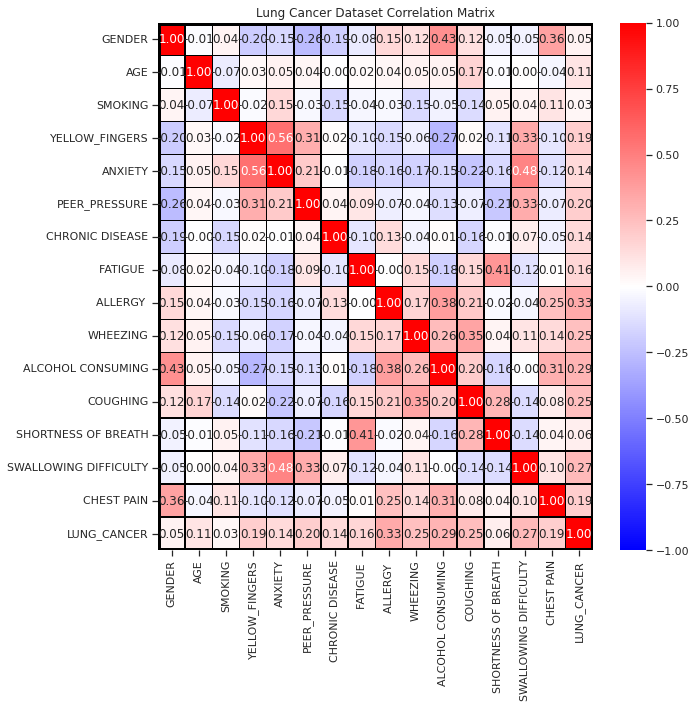

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(10,10))
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True, linewidth=0.5, linecolor='k', fmt='0.2f', cmap='bwr', vmin=-1, vmax=1, ax=axs)
    plt.title("Lung Cancer Dataset Correlation Matrix")
    axs.axhline(y=0, color='k',linewidth=5)
    axs.axhline(y=df_corr.shape[1], color='k',linewidth=4)
    axs.axvline(x=0, color='k',linewidth=5)
    axs.axvline(x=df_corr.shape[0], color='k',linewidth=4)
    plt.tight_layout()
    plt.show()

Generally, it is best to deal with uncorrelated variables. If two variables are correlated, they could describe a similar characteristic about the data set and including them both could result in overweighting that generalized effect. 




 From the above heatmap, we can see that most attributes have minimal correlation. Those that have the highest correlations, such as 'GENDER' and either 'CHEST_PAIN' or 'ALCOHOL_CONSUMPTION' or 'ANXIETY' and either 'DIFFICULTY_SWALLOWING' or 'YELLOW_FINGERS' are obviously relatively independent of one another. There is a correlation, but they aren't necessarily causally linked, so even without strong domain knowledge, we can keep these attributes in our analysis.

#Data Preprocessing


Before we begin with running the models on our dataset.Let's do some preprocessing to prepare for the dataset for model running.

In [ ]:
#Let's split the dependent and independent variables
X = df.drop('LUNG_CANCER',axis=1)
Y = df['LUNG_CANCER']

#Let's partition training data and test data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=42, stratify=Y)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (207, 15)
Test shape: (69, 15)


We observed through EDA that the dataset is highly skewed towards **LUNG_CANCER** being **YES**.Let us resample the training and testing data to balance between the positive and negative samples.

In [ ]:
X_train_resamp, y_train_resamp = RandomOverSampler().fit_resample(X_train, y_train)
X_test_resamp, y_test_resamp = RandomOverSampler().fit_resample(X_test, y_test)
print(f'Train_resampled shape : {X_train_resamp.shape}\nTest_resampled shape: {X_test_resamp.shape}')

Train_resampled shape : (358, 15)
Test_resampled shape: (118, 15)


Let us standardize the values of "AGE" attribute.We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data. We only use transform() on the test data because we use the scaling paramaters learned on the train data to scale the test data.

In [ ]:
scaler = StandardScaler()
X_train_resamp['AGE']=scaler.fit_transform(X_train_resamp[['AGE']])
X_test_resamp['AGE']=scaler.transform(X_test_resamp[['AGE']])
X_train_resamp.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,1,0.220433,1,1,1,1,1,0,0,0,1,0,0,1,1
1,0,0.084373,0,0,0,0,1,1,0,0,0,0,1,0,0
2,0,-0.323809,0,0,0,0,1,1,0,0,0,0,1,0,0
3,1,-1.548353,0,1,0,0,1,1,1,1,1,1,1,0,1
4,1,-0.323809,1,1,1,1,1,0,1,0,1,0,0,1,1


The datasets are ready ,let us run few models and evaluate.

#Model Selection

Let's choose models which runs best for binary classification problem.
The models which we will be using are :

1. k-nearest neighbours
2. Random forest
3. Support Vector Machines

We need to evaluate these 3 models and decide the model which is most accurate as the best model for this dataset.

There are several metrics based on which we can evaluate the performance of a ML model.Precision,recall and accuracy are the usual metrics.

Precision tells us, of the samples that we predict to be positive how many were actually positive.

Recall tells us, of the samples that could have been positive, how many did we correctly predict to be positive.

Accuracy gives us an idea of how good the model is overall, but doesn't give us a metric to account for false negatives.

Since we are working on a dataset which deals with health,it is important to be diagnosed positively if the person is actually suffering from that certain health condition,hence recall can be considered as an important metric to evaluate the performance of the models.



**1.K-Nearest neighbors**

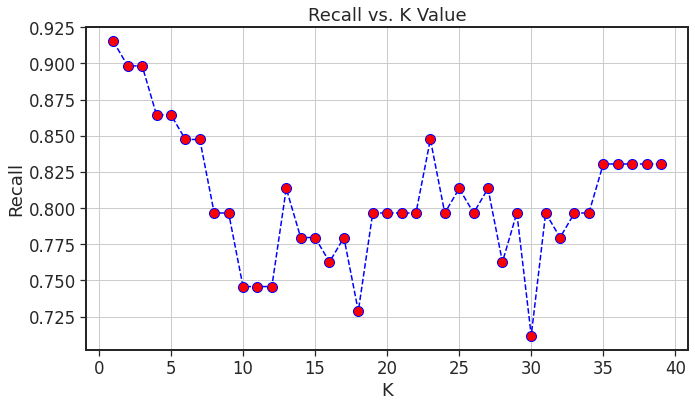

In [ ]:
#let us find recall scores for different neighbour counts 
knn_recall_scores = []

for i in range(1,40):
    knn_i_neighbors = KNeighborsClassifier(n_neighbors = i).fit(X_train_resamp, y_train_resamp)
    y_pred_i_neighbors = knn_i_neighbors.predict(X_test_resamp)
    knn_recall_scores.append(recall_score(y_test_resamp, y_pred_i_neighbors, labels=1))

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(10,6))
    axs.plot(range(1,40), knn_recall_scores, color = 'blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    axs.set_title('Recall vs. K Value')
    axs.set_xlabel('K')
    axs.set_ylabel('Recall')
    # Style, oh yeah
    for spine in ['left', 'top', 'right', 'bottom']:
        axs.spines[spine].set_linewidth(2)
    plt.tight_layout()
    plt.grid()
    plt.show()

We observe that the maximum recall is at K=1,hence we will be choosing K=1 for our KNN model.

In [ ]:
#let's train the model
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_resamp,y_train_resamp)


KNeighborsClassifier(n_neighbors=1)

              precision    recall  f1-score   support

           0       0.86      0.54      0.67        59
           1       0.67      0.92      0.77        59

    accuracy                           0.73       118
   macro avg       0.77      0.73      0.72       118
weighted avg       0.77      0.73      0.72       118



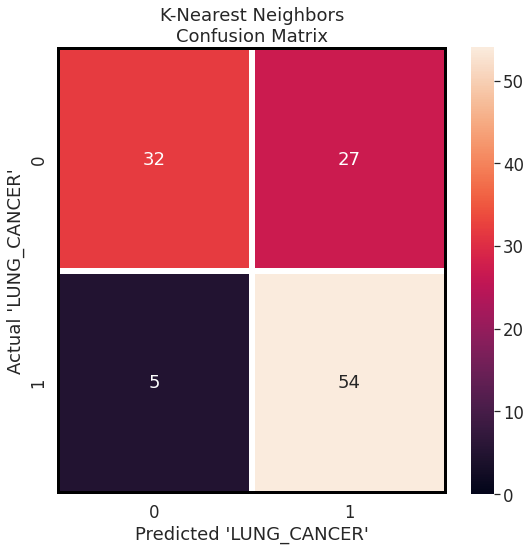

In [ ]:
# KNN Model Evaluation
y_pred_knn = knn.predict(X_test_resamp)

print(classification_report(y_test_resamp, y_pred_knn))

confusion_knn = confusion_matrix(y_test_resamp, y_pred_knn)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("white"):
    fig, axs = plt.subplots(figsize=(8,8))
    sns.heatmap(confusion_knn, annot=True, linewidth=5, vmin=0, cmap='rocket', ax=axs)
    axs.set_title('K-Nearest Neighbors\nConfusion Matrix')
    axs.set_xlabel("Predicted 'LUNG_CANCER'")
    axs.set_ylabel("Actual 'LUNG_CANCER'")
    axs.axhline(y=0, color='k',linewidth=5)
    axs.axhline(y=confusion_knn.shape[1], color='k',linewidth=7)
    axs.axvline(x=0, color='k',linewidth=5)
    axs.axvline(x=confusion_knn.shape[0], color='k',linewidth=7)
    plt.tight_layout()
    plt.show()

In [ ]:
# We are only interested in how well we Recall the 'YES'(1) label for 'LUNG_CANCER'
knn_recall_score = recall_score(y_test_resamp, y_pred_knn, labels=1)
knn_avg_recall_score = recall_score(y_test_resamp, y_pred_knn, average="weighted")
print(f"K-Nearest Neighbors Classifier Recall ('YES'): {knn_recall_score}")

K-Nearest Neighbors Classifier Recall ('YES'): 0.9152542372881356


**2.Random Forest Classifier**

In [ ]:
#Random forest model training
param_grid = { 
    'n_estimators': [25, 30, 40, 50, 75, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8, 9, 10, 11, 12],
    'criterion' :['gini', 'entropy']
}
randfor = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
randfor.fit(X_train_resamp, y_train_resamp)

print(randfor.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.95      0.92      0.93        59
           1       0.92      0.95      0.93        59

    accuracy                           0.93       118
   macro avg       0.93      0.93      0.93       118
weighted avg       0.93      0.93      0.93       118



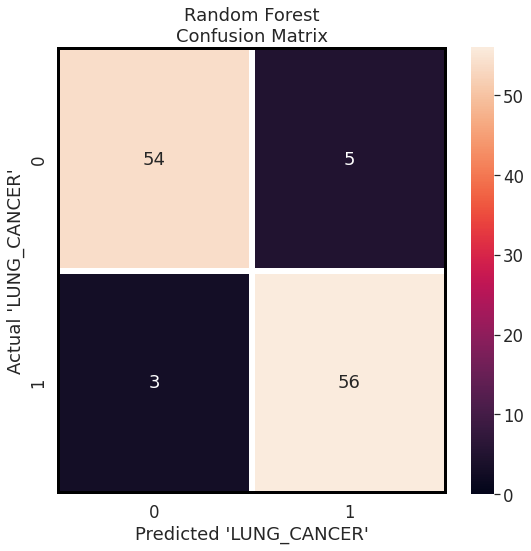

In [ ]:
# Random Forest Model Evaluation
y_pred_randfor = randfor.predict(X_test_resamp)

print(classification_report(y_test_resamp, y_pred_randfor))

confusion_randfor = confusion_matrix(y_test_resamp, y_pred_randfor)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("white"):
    fig, axs = plt.subplots(figsize=(8,8))
    sns.heatmap(confusion_randfor, annot=True, linewidth=5, vmin=0, cmap='rocket', ax=axs)
    axs.set_title('Random Forest\nConfusion Matrix')
    axs.set_xlabel("Predicted 'LUNG_CANCER'")
    axs.set_ylabel("Actual 'LUNG_CANCER'")
    # Style baby! yeah!
    axs.axhline(y=0, color='k',linewidth=5)
    axs.axhline(y=confusion_randfor.shape[1], color='k',linewidth=7)
    axs.axvline(x=0, color='k',linewidth=5)
    axs.axvline(x=confusion_randfor.shape[0], color='k',linewidth=7)
    # Nothing but the classics
    plt.tight_layout()
    plt.show()

In [ ]:
# We are only interested in how well we Recall the 'YES'(1) label for 'LUNG_CANCER'
randfor_recall_score = recall_score(y_test_resamp, y_pred_randfor, labels=1)
randfor_avg_recall_score = recall_score(y_test_resamp, y_pred_randfor, average="weighted")
print(f"Random Forest Classifier Recall ('YES'): {randfor_recall_score}")

Random Forest Classifier Recall ('YES'): 0.9491525423728814


**3.SVM**

In [ ]:
#model training
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C':[0.001,0.01,0.1,1,10,100, 200, 300, 500],
    'gamma':[0.001,0.01,0.1,1,10,100, 200, 300, 500]
}
svc = GridSearchCV(SVC(), param_grid, cv=5)
svc.fit(X_train_resamp, y_train_resamp)

print(svc.best_params_)

{'C': 1, 'gamma': 100, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.50      1.00      0.67        59

    accuracy                           0.50       118
   macro avg       0.25      0.50      0.33       118
weighted avg       0.25      0.50      0.33       118



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


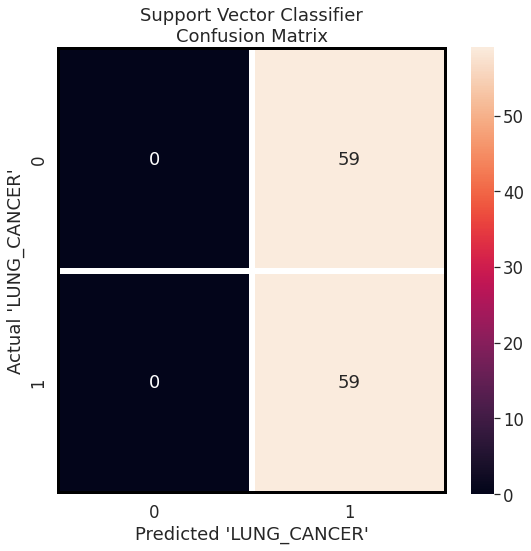

In [ ]:
# SVC Model Evaluation
y_pred_svc = svc.predict(X_test_resamp)

print(classification_report(y_test_resamp, y_pred_svc))

confusion_svm = confusion_matrix(y_test_resamp, y_pred_svc)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("white"):
    fig, axs = plt.subplots(figsize=(8,8))
    sns.heatmap(confusion_svm, annot=True, linewidth=5, vmin=0, cmap='rocket', ax=axs)
    axs.set_title('Support Vector Classifier\nConfusion Matrix')
    axs.set_xlabel("Predicted 'LUNG_CANCER'")
    axs.set_ylabel("Actual 'LUNG_CANCER'")
    axs.axhline(y=0, color='k',linewidth=5)
    axs.axhline(y=confusion_svm.shape[1], color='k',linewidth=7)
    axs.axvline(x=0, color='k',linewidth=5)
    axs.axvline(x=confusion_svm.shape[0], color='k',linewidth=7)  
    plt.tight_layout()
    plt.show()

In [ ]:
# We are only interested in how well we Recall the 'YES'(1) label for 'LUNG_CANCER'
svc_recall_score = recall_score(y_test_resamp, y_pred_svc, labels=1)
svc_avg_recall_score = recall_score(y_test_resamp, y_pred_svc, average="weighted")
print(f"Support Vector Classifier Recall ('YES'): {svc_recall_score}")

Support Vector Classifier Recall ('YES'): 1.0


#FINAL MODEL

Even though we have said that recall is the best metric to evaluate the performance of the model,we cannot consider only one metric to decide the best model.Hence,let us consider both recall and accuracy for the above models and compare those values,keeping in mind that recall is an important metric for this dataset.

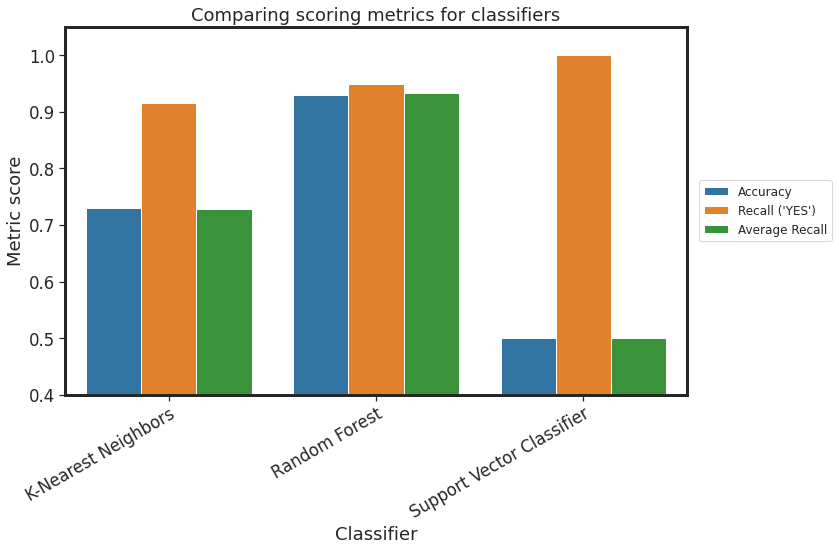

In [ ]:
all_recall_acc_scores = {
    'Classifier':['K-Nearest Neighbors', 'Random Forest', 'Support Vector Classifier'],
    'Accuracy':[0.73,0.93, 0.50],
    "Recall ('YES')":[knn_recall_score, randfor_recall_score,svc_recall_score],
    'Average Recall':[knn_avg_recall_score, randfor_avg_recall_score,svc_avg_recall_score],
}

all_recall_acc_scores = pd.DataFrame(data=all_recall_acc_scores)
all_recall_acc_scores = pd.melt(all_recall_acc_scores, id_vars='Classifier')
all_recall_acc_scores.rename(columns={'variable':'Metric'}, inplace=True)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(12,8))
    sns.barplot(data=all_recall_acc_scores, x='Classifier', y='value', hue='Metric', ax=axs)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')
    axs.set_ylabel('Metric score')
    axs.set_title('Comparing scoring metrics for classifiers')
    axs.set_ylim(0.40, 1.05)
    # Style it baby!
    for spine in ['left', 'top', 'right', 'bottom']:
        axs.spines[spine].set_linewidth(3), 
    plt.legend(bbox_to_anchor=[1.01, 0.5], loc='center left')
    # Nothing but the classics
    plt.tight_layout()
    plt.show()

We see that SVM has the best recall,as it classifies everything as **YES** for **'LUNG_CANCER'**.So considering just recall is a bad choice,hence accuracy should also be considered.We have visualised average recall too.This helps us which model has the best recall for both positive and negative cases for **'LUNG_CANCER'**.

Clearly,Random forest model has the best accuracy,recall for positive cases and average recall.For these reasons,Random forest is considered as the final model for this dataset.

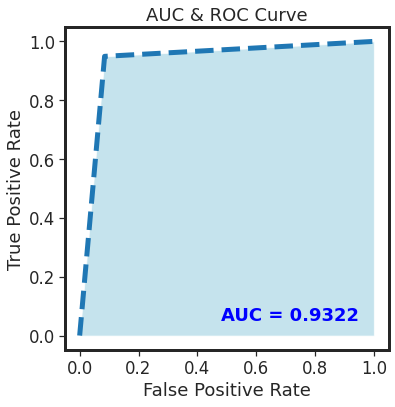

In [ ]:
auc = metrics.roc_auc_score(y_test_resamp, y_pred_randfor)

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test_resamp, y_pred_randfor)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(6,6))
    sns.lineplot(x=false_positive_rate, y=true_positive_rate, linewidth=5, linestyle='--', estimator=None, ax=axs,)
    axs.fill_between(false_positive_rate, true_positive_rate, facecolor='lightblue', alpha=0.7)
    axs.text(0.95, 0.05, f'AUC = {auc:0.4f}', ha='right', weight='bold', color='blue')
    axs.set_title('AUC & ROC Curve')
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    axs.set_xlim([-1, 2])
    axs.set_ylim([-1, 2])
    for spine in ['left', 'top', 'right', 'bottom']:
        axs.spines[spine].set_linewidth(3),
    plt.axis('scaled')
    plt.tight_layout()
    plt.show()

Random forest model exhibited an AUC of 0.9322, which is a great score to validate a model.